In [1]:
import sys
sys.path.append('/Users/philvanlane/Documents/lc_ae')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import os
from pathlib import Path
import time
import json
from mlp_models import MLPAutoencoder, MLPConfig
from data_prep import normalize_ps, normalize_acf

proj_folder = '/Users/philvanlane/Documents/lc_ae/'
mlp_folder = proj_folder + 'mlp/'
artifact_folder = mlp_folder + 'model_artifacts/'

## Load and Prep data

In [2]:
def getPowerSpectra():
    with open(proj_folder + 'pk_star_lc_cf_norm.pickle', 'rb') as f:
        data = pickle.load(f)
    ps = np.array([data[k]['power_1024_norm'] for k in data.keys()])
    ps = ps.astype(np.float32)
    return ps

In [3]:
# Get raw power spectra and ACF
ps_data = getPowerSpectra()
acf_data = np.fft.ifft(ps_data, axis=1).real

norm_ps = np.array([normalize_ps(ps_data[i],scale_factor=50) for i in range(len(ps_data))])
norm_acf = np.array([normalize_acf(acf_data[i],scale_factor=0.001) for i in range(len(acf_data))])

ps_dataset = torch.from_numpy(norm_ps).float()
acf_dataset = torch.from_numpy(norm_acf).float()


## Training

### Data set up

In [5]:
def train_mlp_autoencoder(ae_config, train_config, dataset):
    """Training function for MLP autoencoder"""

    # Initialize model
    model = MLPAutoencoder(
        input_dim=ae_config['input_dim'],
        encoder_hidden_dims=ae_config['encoder_hidden_dims'],
        latent_dim=ae_config['latent_dim'],
        dropout=ae_config['dropout'],
        activation=ae_config['activation']
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Setup training
    train_size = int(train_config['train_split'] * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)


    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=train_config.get('lr', 1e-3), 
                                  weight_decay=train_config.get('weight_decay', 1e-4))
    
    # Choose loss function
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    epochs = train_config.get('epochs', 50)
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    
    print(f"Starting training for {epochs} epochs...")
    print(f"Model has {model.count_parameters():,} parameters")
    print(f"Compression ratio: {model.get_compression_ratio():.1f}x")
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output['reconstructed'], batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output['reconstructed'], batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 20 == 0 or epoch == epochs - 1 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.2e}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.1f} seconds")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return model, train_losses, val_losses, learning_rates

### Train

In [28]:
datatype = 'acf'
version = 'v02'
ae_config = {
    'input_dim': 1024,
    'encoder_hidden_dims': [512, 256],
    'latent_dim': 128,
    'dropout': 0.1,
    'activation': 'gelu'
}
train_config = {
    'batch_size': 32,
    'epochs': 200,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'loss_type': 'mse',  # 'mse' or 'log_mse'
    'train_split': 0.8
}

Starting training for 200 epochs...
Model has 1,382,016 parameters
Compression ratio: 8.0x
Epoch   1: Train Loss = 0.753594, Val Loss = 0.520259, LR = 1.00e-03
Epoch  20: Train Loss = 0.220028, Val Loss = 0.230689, LR = 1.00e-03
Epoch  40: Train Loss = 0.177180, Val Loss = 0.200835, LR = 1.00e-03
Epoch  60: Train Loss = 0.158604, Val Loss = 0.190537, LR = 1.00e-03
Epoch  80: Train Loss = 0.149155, Val Loss = 0.186711, LR = 1.00e-03
Epoch 100: Train Loss = 0.141792, Val Loss = 0.183430, LR = 1.00e-03
Epoch 120: Train Loss = 0.135749, Val Loss = 0.180388, LR = 1.00e-03
Epoch 140: Train Loss = 0.124808, Val Loss = 0.173775, LR = 5.00e-04
Epoch 160: Train Loss = 0.118039, Val Loss = 0.170441, LR = 2.50e-04
Epoch 180: Train Loss = 0.116405, Val Loss = 0.169133, LR = 1.25e-04
Epoch 200: Train Loss = 0.114934, Val Loss = 0.168587, LR = 6.25e-05
Training completed in 113.0 seconds
Best validation loss: 0.168537


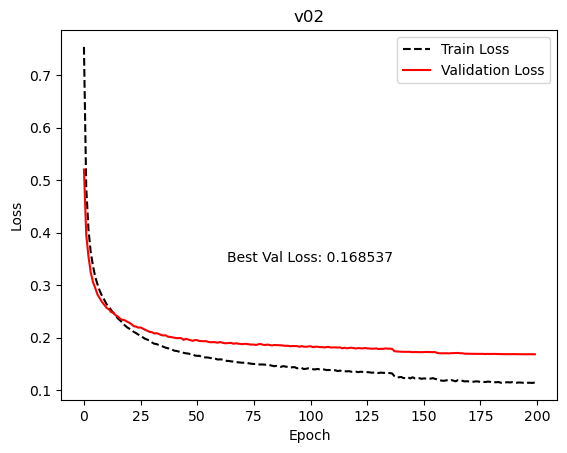

In [29]:
model, train_losses, val_losses, learning_rates = train_mlp_autoencoder(
        ae_config, train_config, acf_dataset
    )

if datatype == 'ps':
    save_folder = artifact_folder + "ps/"
elif datatype == 'acf':
    save_folder = artifact_folder + "acf/"

# Save parameters
torch.save(model.state_dict(), save_folder + version + "_mlp_ae.pt")
np.save(save_folder + version + "_training_data.npy", np.array([train_losses,val_losses,learning_rates]))

# Save configs
log_data = {
    'version': version,
    'datatype': datatype,
    'ae_config': ae_config,
    'train_config': train_config,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'num_parameters': model.count_parameters(),
    'compression_ratio': model.get_compression_ratio()
}

with open(f"{save_folder}{version}_config_log.json", "w") as f:
    json.dump(log_data, f, indent=2)


# Plot
plt.plot(train_losses, label='Train Loss',color='black',linestyle='dashed')
plt.plot(val_losses, label='Validation Loss',color='red')
best_val_loss = min(val_losses)
plt.text(train_config.get('epochs')/2, (max(val_losses) + best_val_loss)/2,
         f'Best Val Loss: {best_val_loss:.6f}', fontsize=10, ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(version)
plt.legend()
plt.savefig(save_folder + version + "_losses.png")
plt.show()



## Test reconstructions

### Recreate model

In [30]:
version = 'v02'
save_folder = artifact_folder + "acf/"
dataset = acf_dataset

with open(f"{save_folder}{version}_config_log.json", "r") as f:
    model_config = json.load(f)

model = MLPAutoencoder(
        input_dim=model_config['ae_config']['input_dim'],
        encoder_hidden_dims=model_config['ae_config']['encoder_hidden_dims'],
        latent_dim=model_config['ae_config']['latent_dim'],
        dropout=model_config['ae_config']['dropout'],
        activation=model_config['ae_config']['activation']
)
model.load_state_dict(torch.load(save_folder + version + "_mlp_ae.pt"))


<All keys matched successfully>

### Plot random reconstruction

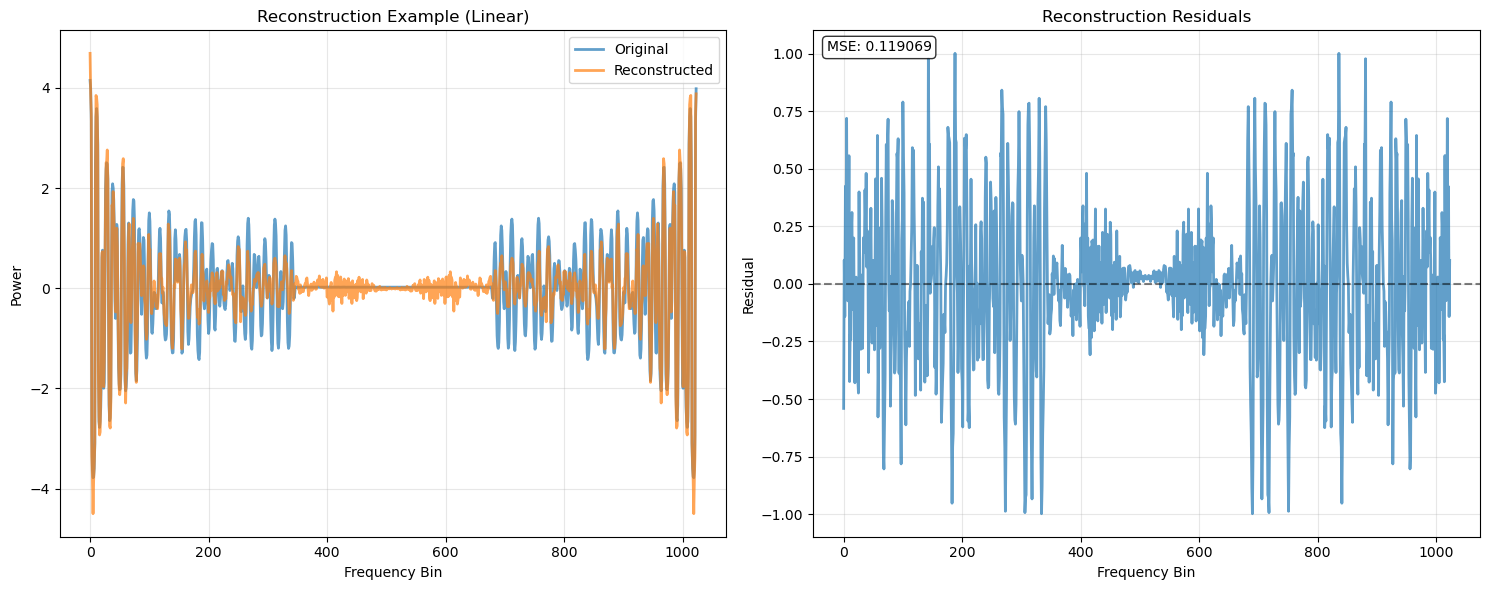

In [69]:
model.eval()

# New test data
loader = DataLoader(dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    sample_batch = next(iter(loader))[:1].to('cpu')
    output = model(sample_batch)
    
    original = sample_batch[0].cpu().numpy()
    reconstructed = output['reconstructed'][0].cpu().numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale reconstruction
axes[0].plot(original, label='Original', alpha=0.7, linewidth=2)
axes[0].plot(reconstructed, label='Reconstructed', alpha=0.7, linewidth=2)
axes[0].set_xlabel('Frequency Bin')
axes[0].set_ylabel('Power')
axes[0].set_title('Reconstruction Example (Linear)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residual = original - reconstructed
axes[1].plot(residual, alpha=0.7, linewidth=2)
axes[1].set_xlabel('Frequency Bin')
axes[1].set_ylabel('Residual')
axes[1].set_title('Reconstruction Residuals')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

mse = np.mean((original - reconstructed) ** 2)
axes[1].text(0.02, 0.98, f'MSE: {mse:.6f}', transform=axes[1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()